In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

import preprocess_utils as pu 

(55.556484943908679, 130.22858292486649, 92.892533934387586)
(55.556484943908679, 130.22858292486649, 92.892533934387586)
(256,)
(256,)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in divide


(<matplotlib.axes._subplots.AxesSubplot at 0x7f710bfe40d0>,
 (-0.5, 149.5, 249.5, -0.5),
 <matplotlib.text.Text at 0x7f710bf20510>)

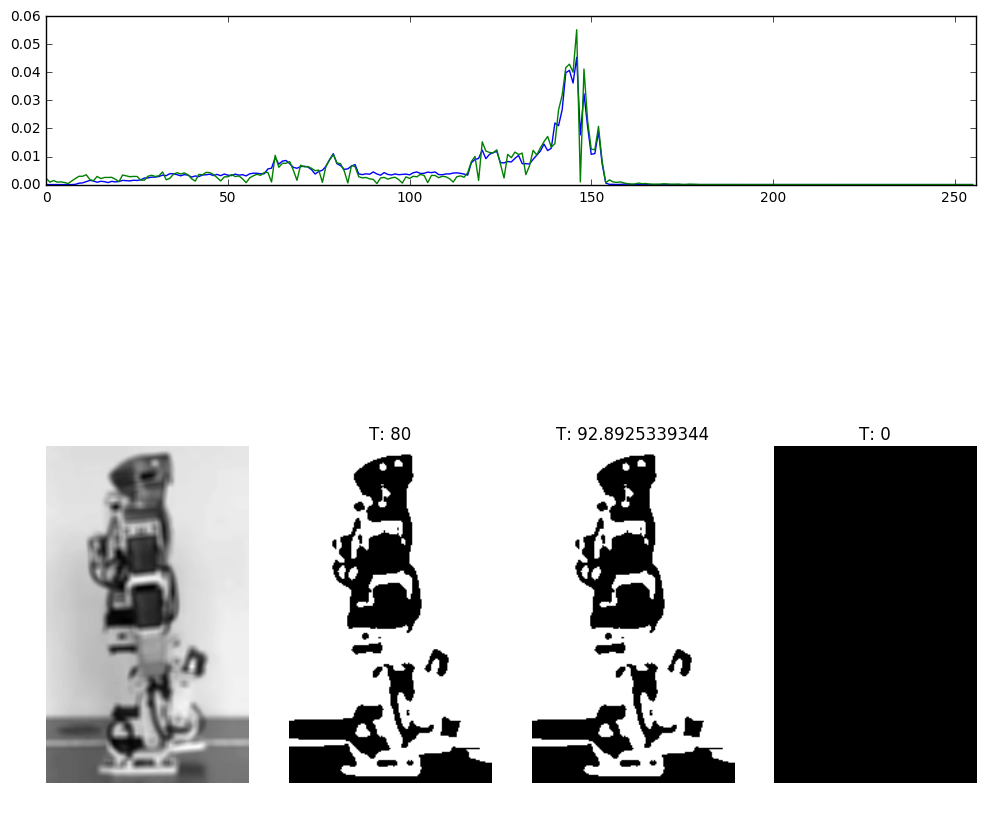

In [59]:
# segmentation thresholding

img = cv2.imread('data/biowalk-0300.png',cv2.IMREAD_GRAYSCALE)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[:,:,2]

scl = 1
img_orig = cv2.resize(img[85:335, 150:300],None,fx=scl, fy=scl, interpolation = cv2.INTER_CUBIC)

#img_blur = img_orig
img_blur = cv2.blur(img_orig,(5,5))
#img_blur = cv2.medianBlur(img_orig,5)
#img_blur = cv2.GaussianBlur(img_orig,(5,5),2,2)

# 1. Global thresholding
# 2. Variable thresholding
#    a. Local or Regional thresholding
#    b. Dynamic or Adaptive thresholding
T0 = 80
img_seg = np.zeros_like(img_blur)
img_seg[img_blur>T0] = 1 

T, n, nmax, tol = T0, 0, 10, 0.001
img_seg2 = np.zeros_like(img_blur)
img_seg2[img_blur>T] = 1
while True:
    G1, G2 = img_seg2==0, img_seg2==1
    m1, m2 = np.sum(img_blur[G1])/np.sum(G1), np.sum(img_blur[G2])/np.sum(G2)
    T, Told, n = 0.5*(m1+m2), T, n+1
    img_seg2[img_blur>T] = 1
    print(m1,m2,T)
    if np.abs(T-Told)<tol or n==nmax:
        break

# Histogram
hist_full = cv2.calcHist([img_blur],[0],None,[256],[0,256])
hist_orig = cv2.calcHist([img_orig],[0],None,[256],[0,256])

# Otsu's algorithm
L,N,M = 256,img_blur.shape[0],img_blur.shape[1]
p = np.reshape(hist_full,(L,))/(N*M)
P = np.cumsum(p)
m = np.cumsum(np.arange(0,L)*p)
mG = m[-1]
print(p.shape)
print(np.arange(0,L).shape)
sigB2 = (mG*P-m)**2/P/(1-P)
sigG2 = np.cumsum((np.arange(0,L)-mG)**2*p)
kp = np.argmax(sigB2)
nup = sigB2[kp]/sigG2
img_seg3 = np.zeros_like(img_blur)
img_seg3[img_blur>kp] = 1

plt.figure(figsize=(12,10))
plt.subplot(4,1,1),plt.plot(hist_full/N/M), plt.plot(hist_orig/N/M), plt.xlim([0,256])
plt.subplot(2,4,5),plt.imshow(img_blur, 'gray'), plt.axis('off')
plt.subplot(2,4,6),plt.imshow(img_seg, 'gray'), plt.axis('off'), plt.title('T: '+str(T0))
plt.subplot(2,4,7),plt.imshow(img_seg2, 'gray'), plt.axis('off'), plt.title('T: '+str(T))
plt.subplot(2,4,8),plt.imshow(img_seg3, 'gray'), plt.axis('off'), plt.title('T: '+str(kp))
